In [1]:
from transformers import AutoModel, AutoProcessor
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def shift_hue(image, shift):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 0] = (hsv[..., 0].astype(int) + shift) % 180
    shifted_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return shifted_image

def run_clip(images):
    clip_model = AutoModel.from_pretrained("openai/clip-vit-base-patch32")
    clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
    # clip_model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
    # clip_processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
    pil_images = [Image.fromarray(image) for image in images]

    with torch.no_grad():
        inputs = clip_processor(images=pil_images, return_tensors="pt")
        outputs = clip_model.get_image_features(**inputs)
        return outputs

def run_dino(images):
    # dino_processor = AutoProcessor.from_pretrained('facebook/dino-vitb8')
    # dino_model = AutoModel.from_pretrained('facebook/dino-vitb8')
    dino_processor = AutoProcessor.from_pretrained('facebook/dino-vits16')
    dino_model = AutoModel.from_pretrained('facebook/dino-vits16')
    pil_images = [Image.fromarray(image) for image in images]

    with torch.no_grad():
        inputs = dino_processor(images=pil_images, return_tensors="pt")
        outputs = dino_model(**inputs)
        last_hidden_states = outputs.pooler_output 
        return last_hidden_states

def concatenate_images_horizontally(images_array, output_path):
    # 画像を読み込む
    images = [Image.fromarray(images) for images in images_array]
    
    # 各画像の幅と高さを取得
    widths, heights = zip(*(image.size for image in images))
    
    # 合計幅と最大高さを計算
    total_width = sum(widths)
    max_height = max(heights)
    
    # 結合後の新しい画像を作成
    new_image = Image.new('RGB', (total_width, max_height))
    
    # 各画像を新しい画像に順に貼り付ける
    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width
    
    # 新しい画像を保存
    new_image.save(output_path)

def main(base_image_path):
    base_img = cv2.imread(base_image_path)
    shifted_images = []
    for i in range(0, 360, 20):
        shifted_img = shift_hue(base_img, i // 2) # OpenCVの色相は0-179の範囲で操作する
        shifted_img = cv2.cvtColor(shifted_img, cv2.COLOR_BGR2RGB)
        shifted_images.append(shifted_img)
    
    all_images = [cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)] + shifted_images
    concatenate_images_horizontally(all_images, "all_images.jpg")

    clip_outputs = run_clip(all_images)
    clip_simirarity = cosine_similarity(clip_outputs[0:1], clip_outputs[1:])[0]
    print(clip_simirarity)

    dino_outputs = run_dino(all_images)
    dino_simirarity = cosine_similarity(dino_outputs[0:1], dino_outputs[1:])[0]
    print(dino_simirarity)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    x_array = list(range(0, 360, 20))
    ax.plot(x_array, clip_simirarity, label="CLIP ViT-B/32")
    ax.plot(x_array, dino_simirarity, label="DINO ViT-S/16")
    ax.set_ylabel("Similarity")
    ax.set_xlabel("Hue Shift")
    ax.legend()
    # plt.savefig("similarity.png")
    plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[0.99994004 0.993057   0.97181344 0.9654467  0.961665   0.9511952
 0.96978486 0.9678042  0.9523444  0.93356544 0.9296479  0.9183695
 0.91473365 0.9051001  0.88960934 0.93547064 0.9677608  0.96571517]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0.9999815  0.9972128  0.97882843 0.943807   0.9174019  0.89062643
 0.88119066 0.8741118  0.8614275  0.85908157 0.8599145  0.88361645
 0.90191996 0.91029847 0.92439497 0.93378687 0.95125306 0.9821811 ]


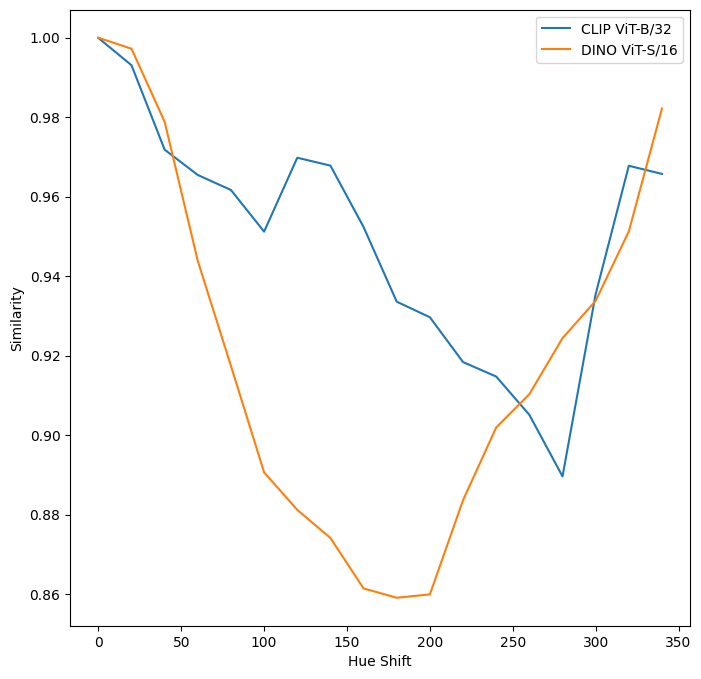

In [3]:
main("apple.jpg")